<a href="https://colab.research.google.com/github/nachoguirado/pruebaUE/blob/main/Reto_2%2C_Nacho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random

import numpy as np
import pandas as pd
from sklearn import cluster      # Algoritmos de clustering.
from sklearn import datasets     # Crear datasets.
from sklearn import manifold     # Algoritmos de reduccion de dimensionalidad.
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA
import sklearn.neighbors
from sklearn.neighbors import kneighbors_graph
# Visualizacion.
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Aplicación: identificación de puntos de interés turísticos 

En este reto se busca automatizar la localización de lugares turísticos a través de los metadatos de las fotografías de flickr.

Para ello se provee junto al notebook del reto el dataset: ``barcelona.csv``. Ya que se pide encontrar los puntos de mayor interés turístico de esta ciudad.

**Opcional: si quieres hacerlo para otra región**

Pero si quieres hacerlo para otra parte del mundo, puedes descargarte el dataset completo [aquí](https://drive.google.com/file/d/0B-mRR4rjwHPONVFfX2VmTmxZcHM/view?usp=sharing) y descomprime para extraer el *CSV*.

Para seleccionar las coordenadas de la zona de interés puedes usar la opción *Export* manual de [OpenStreetMaps](https://www.openstreetmap.org/).

Por último, para filtrar los datos que se corresponden a la zona deseada puedes usar el programa *AWK* mediante la siguiente línea:

``awk -F"," 'NR == 1 {print $5","$6} (NR > 1 && $5 > 41.3560 && $5 < 41.4267 && $6 > 2.1300 && $6 < 2.2319) {print $5","$6}' photo_metadata.csv``

``$5`` hace referencia a la latitud, y ``$6`` a la longitud. Sustituye los valores mínimo y máximo para obtener los datos de localización referentes a tu área de interés.

In [3]:
geo_df = pd.read_csv('barcelona.csv', header=0)
geo_df.sample(5)

,latitude,longitude
16703,41.370166,2.153833
10635,41.382347,2.195119
2382,41.386500,2.155999
10401,41.386750,2.171816
12632,41.375886,2.148964


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> siempre que tratamos un problema real, es necesario entender los datos a tratar. Visualiza las localizaciones de las fotografías mediante un scatter plot. Prueba distintos parámetros de tamaño (<i>size</i>) <i>s</i>, y opacidad <i>alpha</i> hasta conseguir un resultado fácil de interpretar. 
</div>

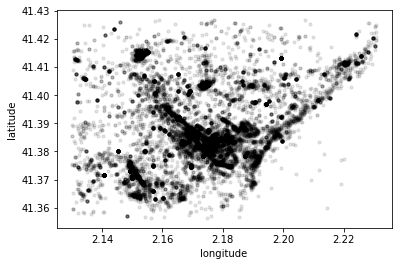

In [8]:
plot = geo_df.plot.scatter(
    x='longitude',y='latitude',s=10, c='black', alpha = 0.10)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> tras haber probado los algoritmos de agrupamiento en el ejercicio 1. ¿Qué algoritmo crees que sería más adecuado tras visualizar los datos? ¿Por qué?
</div>

In [8]:
"""Dado que estamos utilizando un scatter plot y con la variable alpha podemos modificar la opacidad,
 para ver la densidad de los resultados plasmados en la gráfica creo que el
algoritmo que más nos conviene utilizar en este caso es el dbscan(density-based algorithm),
 ya que su clustering está basado en la densidad y así podremos clusterizar los distintos
 barrios, y asi dividir la ciudad por zonas"""

'Dado que estamos utilizando un scatter plot y con la variable alpha podemos modificar la opacidad,\n para ver la densidad de los resultados plasmados en la gráfica creo que el\nalgoritmo que más nos conviene utilizar en este caso es el dbscan(density-based algorithm),\n ya que su clusteringe está basado en la densidad y así poder ver en que áreas existen \n concentraciones de puntos y dónde están separados por áreas vacías o con escasos puntos.'

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> para prototipar el modelado primero se recomienda elegir un subconjunto de los datos que sea representativo. Selecciona una muestra del DataFrame original y visualiza como en el punto anterior para comprobar su similitud. 
</div>

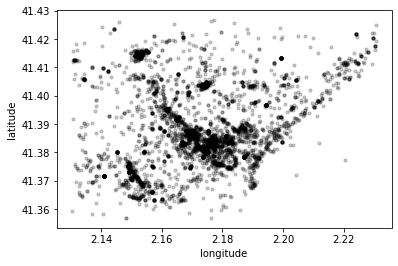

In [10]:
sample_geo_df = geo_df.sample(5000)
sample_plot = sample_geo_df.plot.scatter(x='longitude',y='latitude',s=10, c='black',alpha=0.20)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> ajusta el algoritmo de clustering elegido para encontrar los distintos grupos sobre el conjunto reducido, y visualiza el resultado coloreando cada punto en base al grupo al que pertenece. Como pista, alrededor de 20 clusters es un número razonable, y es posible darles un color distinto a cada uno con el <i>colormap: tab20</i>.
</div>

In [12]:
#Normalizamos los datos con MinMax()
min_max_scaler = preprocessing.MinMaxScaler()
df_normalizado = min_max_scaler.fit_transform(geo_df)
df_normalizado = pd.DataFrame(df_normalizado)
df_normalizado = df_normalizado.rename(columns ={0:'latitude', 1:'longitude'})
df_normalizado

,latitude,longitude
0,0.816376,0.227352
1,0.417545,0.397063
2,0.491376,0.657574
3,0.895440,0.243089
4,0.895440,0.243089
...,...,...
19311,0.671402,0.439483
19312,0.816376,0.227352
19313,0.816376,0.227352
19314,0.816376,0.227352


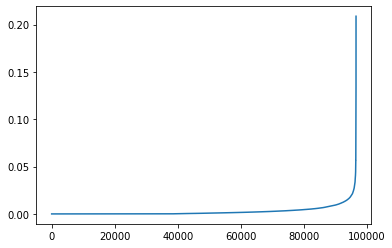

In [13]:
#Aqui estimamos utilizando la tecnica del codo
estimator = PCA (n_components = 2)
X_pca = estimator.fit_transform(df_normalizado)
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
matsim = dist.pairwise(X_pca)
minPts  = 5 # Fijamos el parámetro minPts
A = kneighbors_graph(X_pca, minPts, include_self=False)
Ar = A.toarray()
seq = []
for i,s in enumerate(X_pca):
    for j in range(len(X_pca)):
        if Ar[i][j] != 0:
            seq.append(matsim[i][j])
seq.sort()
plt.plot(seq)
plt.show()

Observamos en la curva elbow que podemos fijar el valor del radio epsilon entre 0,010 y 0,020 aproximadamente, que es donde empieza a crecer exponencialmente. Asi que vamos a coger 0,017 .

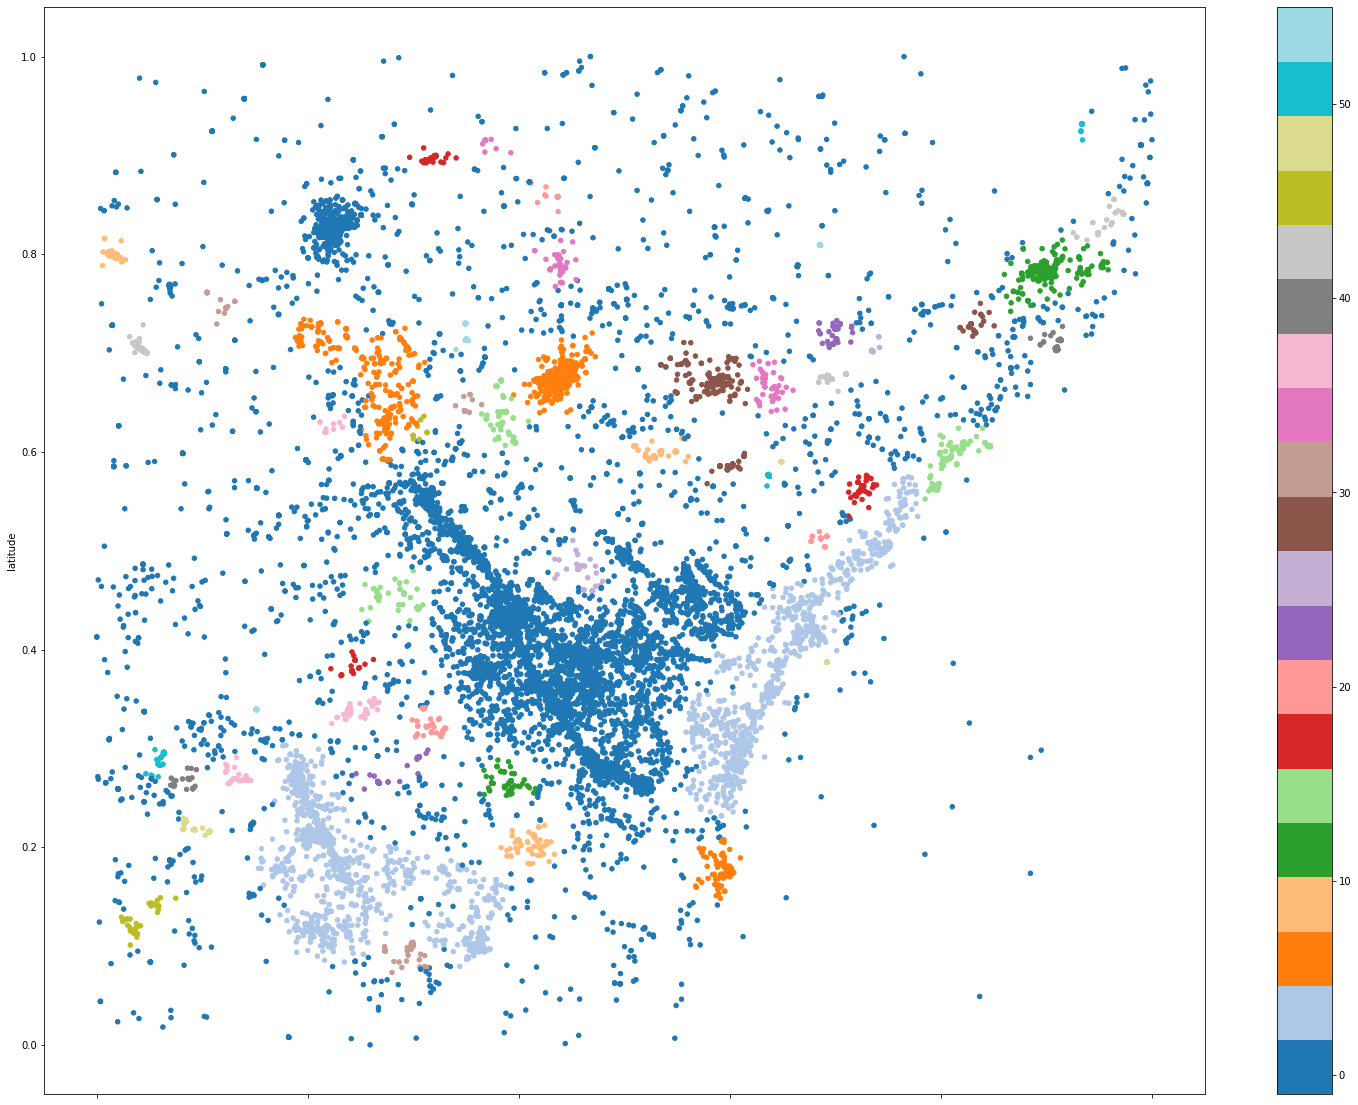

In [22]:
dbscan = DBSCAN(eps=0.015, min_samples=20,algorithm='brute',p=0.9)
clusters =dbscan.fit_predict(df_normalizado)
df_normalizado.plot(kind='scatter',x='longitude',y='latitude',c=clusters,cmap='tab20',figsize=(26,20))

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> si has usado un método de <i>clustering</i> que permite la detección de <i>outliers</i>. Representa sólo los puntos que no ha considerado <i>outliers</i>, es decir, los que pertenecen a algún <i>cluster</i>.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> interpreta cual es el lugar que representa cada <i>cluster</i> (si encuentras una asociación lógica).
</div>

In [ ]:
He encontrado 12 clusters, uno representa la sagrada familia, otro el camp nou, otro toda la parte
del paseo maritimo y la estatua de colon, el parque guell, el centro comercial gran via 2, 
y el hospital del llobregat.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>OPCIONAL Implementación:</strong> representa los puntos sin ruido sobre un mapa utilizando la librería <a href="https://pypi.org/project/smopy/">Smopy</a>. Para facilitar la interpretación, puedes representar cada cluster como el punto medio de todos los puntos que lo conforman.
</div>